# TELECOM CUSTOMER CHURN ANALYSIS

**1. Импорт библиотек**

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**2. Чтение данных**

In [137]:
churn_df = pd.read_csv('telecom_customer_churn.csv')
churn_df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


**3. Проверка данных**

In [138]:
churn_df.shape

(7043, 38)

In [139]:
churn_df.isna().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download              1526
Online Security                      1526
Online Backup                        1526
Device Protection Plan               1526
Premium Tech Support                 1526
Streaming TV                         1526
Streaming Movies                  

In [141]:
churn_df[['Avg Monthly Long Distance Charges', 'Multiple Lines']]

,Avg Monthly Long Distance Charges,Multiple Lines
0,42.39,No
1,10.69,Yes
2,33.65,No
3,27.82,No
4,7.38,No
...,...,...
7038,46.68,No
7039,16.20,Yes
7040,18.62,No
7041,2.12,No


Из описания данных колонок:

**Avg Monthly Long Distance Charges** - Indicates the customer’s average long distance charges, calculated to the end of the quarter specified above (if the customer is not subscribed to home phone service, this will be 0);

**Multiple Lines** - Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No (if the customer is not subscribed to home phone service, this will be No)

Данные колонки связаны друг с другом. Можно было бы считать, что пустые значения в *Multiple Lines* равны *No*. Но по значениям *No* в колонке *Avg Monthly Long Distance Charges* есть значения.

Поэтому пока оставим пустые значения, как есть. Если в дальнейшем нам потребуется работать с этими ячейками, примем решения, на что их заменить.

Пустые значения в колонках интернет показателей также оставим, как есть.
Колонки *Churn Category* и *Churn Reason* рассмотрим чуть позже. Пока ориентируемся на колонку *Customer Status*, в которой есть значение *Churned*.

In [142]:
churn_df.dtypes

Customer ID                           object
Gender                                object
Age                                    int64
Married                               object
Number of Dependents                   int64
City                                  object
Zip Code                               int64
Latitude                             float64
Longitude                            float64
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Avg Monthly GB Download              float64
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object
Streaming 

С типами данных все в порядке, оставляем как есть.

**4. Анализ данных**

Для начала посмотрим, как пользователи распределены по статусам:

In [143]:
churn_df \
    .groupby('Customer Status') \
    .agg({'Customer ID': 'count'}) \
    .rename(columns={'Customer ID': 'Customers'})

,Customers
Customer Status,
Churned,1869
Joined,454
Stayed,4720


Попробуем оценить профиль средего клиента в каждой категории:

1) Пол клиента

In [144]:
churn_df \
    .groupby(['Customer Status', 'Gender']) \
    .agg({'Gender': 'count'}) \
    .rename(columns={'Gender': 'Customers'}) \
    .reset_index() \
    .pivot(index='Customer Status', columns='Gender', values='Customers') \
    .reset_index()

Gender,Customer Status,Female,Male
0,Churned,939,930
1,Joined,211,243
2,Stayed,2338,2382


Здесь без дополнительных расчетов видно, что все категории делятся по полу примерно 50/50.

2) Возраст клиента

In [145]:
customer_status_by_age_df = churn_df \
    .groupby('Customer Status', as_index=False) \
    .agg({'Age': 'mean'}) \
    .rename(columns={'Age': 'Average_age'}) \
    .round({'Average_age': 1})

customer_status_by_age_df

,Customer Status,Average_age
0,Churned,49.7
1,Joined,42.9
2,Stayed,45.6


Видно, что средние значения различаются.
Cтатитическую значимость проверять пока не будем, т.к. маловероятно, что уход пользователей связан с возрастом.
Это будет иметь смысл проверить, если не найдем других инсайтов.

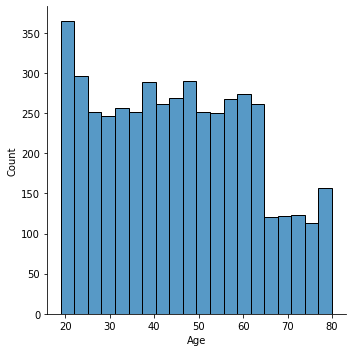

In [146]:
Stayed_customers_df = churn_df[churn_df['Customer Status'] == 'Stayed']
sns.displot(data=Stayed_customers_df, x="Age")

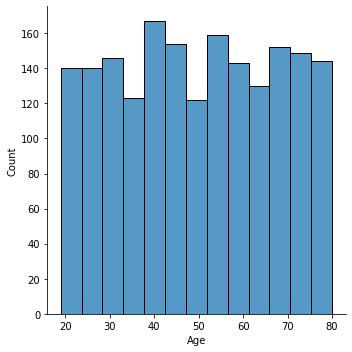

In [147]:
Churned_customers_df = churn_df[churn_df['Customer Status'] == 'Churned']
sns.displot(data=Churned_customers_df, x="Age")

Визуально видно, что оставшиеся клиенты в среднем более молодые.
Тогда как у ушедших клиентов нет зависимости от возраста.
Это подтверждает вывод, что искать причины ухода клиентов в их возрасте не имеет смысла.

3) Покупатели по городам

Посмотрим, сколько клиентов приходится на каждую из групп по городам:

In [148]:
customers_by_city_df = churn_df \
    .groupby(['Customer Status', 'City'], as_index=False) \
    .agg({'Age': 'count'}) \
    .pivot(index='City', columns='Customer Status', values='Age') \
    .fillna(0)

customers_by_city_df['Total'] = customers_by_city_df['Churned'] + customers_by_city_df['Joined'] + customers_by_city_df['Stayed']
customers_by_city_df.sort_values(by='Total', ascending=False)

Customer Status,Churned,Joined,Stayed,Total
City,,,,
Los Angeles,78.0,18.0,197.0,293.0
San Diego,185.0,7.0,93.0,285.0
San Jose,29.0,2.0,81.0,112.0
Sacramento,26.0,6.0,76.0,108.0
San Francisco,31.0,7.0,66.0,104.0
...,...,...,...,...
South Lake Tahoe,2.0,0.0,0.0,2.0
Jacumba,0.0,1.0,1.0,2.0
Johannesburg,2.0,0.0,0.0,2.0




Оставим только города с общим числом клиентов более 50:

In [149]:
top_cities_df = customers_by_city_df[customers_by_city_df['Total'] >= 50]
top_cities_df.sort_values(by='Total', ascending=False)

Customer Status,Churned,Joined,Stayed,Total
City,,,,
Los Angeles,78.0,18.0,197.0,293.0
San Diego,185.0,7.0,93.0,285.0
San Jose,29.0,2.0,81.0,112.0
Sacramento,26.0,6.0,76.0,108.0
San Francisco,31.0,7.0,66.0,104.0
Fresno,13.0,0.0,48.0,61.0
Long Beach,15.0,2.0,43.0,60.0
Oakland,13.0,5.0,34.0,52.0
Escondido,16.0,3.0,32.0,51.0


Посчитаем долю ушедших клиентов по городам:

In [150]:
top_cities_df = top_cities_df[['Churned', 'Total']]
top_cities_df['Churned_share'] = np.round(top_cities_df['Churned'] / top_cities_df['Total'] * 100, 1)
top_cities_df.sort_values(by='Churned_share', ascending=False)

Customer Status,Churned,Total,Churned_share
City,,,
San Diego,185.0,285.0,64.9
Escondido,16.0,51.0,31.4
San Francisco,31.0,104.0,29.8
Los Angeles,78.0,293.0,26.6
San Jose,29.0,112.0,25.9
Long Beach,15.0,60.0,25.0
Oakland,13.0,52.0,25.0
Sacramento,26.0,108.0,24.1
Fresno,13.0,61.0,21.3


**Видно, что что-то случилось в Сан Диего.**

Причем, как и по количеству ушедших клиентов, так и по доле ушедших клиентов от общего их числа.
Ушли почти 65% клиентов.

Посмотрим данные по ушедшим клиентам из Сан Диего:

In [176]:
churned_san_diego_customers_df = churn_df[(churn_df['City'] == 'San Diego') & (churn_df['Customer Status'] == 'Churned')]
churned_san_diego_customers_df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
40,0067-DKWBL,Male,69,No,0,San Diego,92129,32.961064,-117.134917,0,...,Bank Withdrawal,49.25,91.10,0.00,0,87.98,179.08,Churned,Competitor,Competitor made better offer
75,0122-OAHPZ,Female,29,No,0,San Diego,92122,32.857230,-117.209774,0,...,Bank Withdrawal,73.85,511.25,13.03,0,200.34,698.56,Churned,Competitor,Competitor made better offer
126,0219-YTZUE,Male,26,Yes,0,San Diego,92122,32.857230,-117.209774,5,...,Bank Withdrawal,84.80,371.90,0.00,0,115.08,486.98,Churned,Competitor,Competitor made better offer
131,0224-HJAPT,Male,25,No,0,San Diego,92117,32.825086,-117.199424,0,...,Bank Withdrawal,47.15,223.15,0.00,0,110.05,333.20,Churned,Competitor,Competitor made better offer
159,0259-GBZSH,Male,22,No,0,San Diego,92122,32.857230,-117.209774,0,...,Bank Withdrawal,85.65,181.50,0.00,0,80.86,262.36,Churned,Competitor,Competitor made better offer


Посмотрим причины ухода:

In [152]:
churned_san_diego_customers_df \
    .groupby('Churn Category') \
    .agg({'Age': 'count'})

,Age
Churn Category,
Attitude,10
Competitor,152
Dissatisfaction,6
Other,15
Price,2


82% ушедших клиентов стали пользоваться услугами конкурентов.
Посмотрим причины ухода к конкурентам:

In [153]:
churned_to_competitor_san_diego_customers_df = churned_san_diego_customers_df[churned_san_diego_customers_df['Churn Category'] == 'Competitor']
churned_to_competitor_san_diego_customers_df.groupby('Churn Reason').agg({'Age': 'count'})

,Age
Churn Reason,
Competitor had better devices,6
Competitor made better offer,146


Видно, что предложение конкурентов существенно лучше, что становится причиной перехода клиентов к ним. А это потеря 65% клиентов. Так что предложение конкурентов сильно лучше.

4) Срок пользования услугами

In [154]:
customer_length_df = churn_df \
    .groupby('Customer Status', as_index=False) \
    .agg({'Tenure in Months': 'mean'})

customer_length_df

,Customer Status,Tenure in Months
0,Churned,17.979133
1,Joined,1.720264
2,Stayed,41.041525


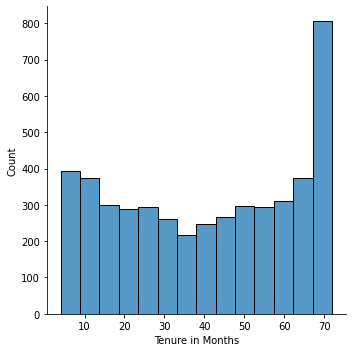

In [155]:
Stayed_customers_df = churn_df[churn_df['Customer Status'] == 'Stayed']
sns.displot(data=Stayed_customers_df, x="Tenure in Months")

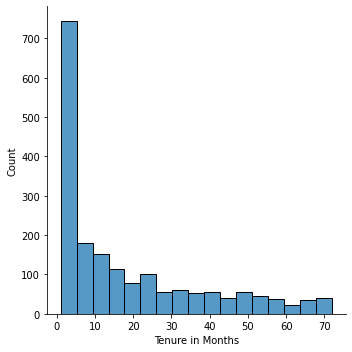

In [156]:
Churned_customers_df = churn_df[churn_df['Customer Status'] == 'Churned']
sns.displot(data=Churned_customers_df, x="Tenure in Months")

Интересная картина. БОльшая часть ушедших клиентов ушла, проведя с компанией менее 5 месяцев. 
При этом есть большое число лояльных клиентов, которые пользуются услугами компании на протяжении 5-6 лет.
Т.е. тенденция говорит о том, что проблемы начались в последние месяцы.

Посмотрим более детально на распределение внутри этих 5 месяцев:

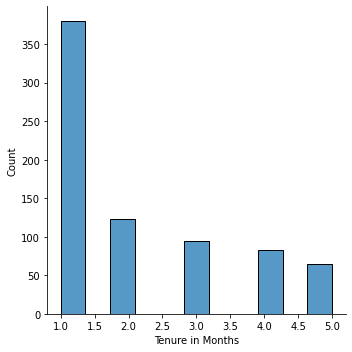

In [157]:
Churned_customers_df = churn_df[(churn_df['Customer Status'] == 'Churned') & (churn_df['Tenure in Months'] <= 5)]
sns.displot(data=Churned_customers_df, x="Tenure in Months")

Более половины клиентов из них подключились в последний месяц.

Отсортируем и посмотрим, что там не так:

In [177]:
Churned_customers_last_month_df = churn_df[(churn_df['Customer Status'] == 'Churned') & (churn_df['Tenure in Months'] < 2)]
Churned_customers_last_month_df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
19,0023-HGHWL,Male,67,No,0,Morgan Hill,95037,37.161544,-121.649371,0,...,Bank Withdrawal,25.10,25.10,0.0,0,0.00,25.10,Churned,Competitor,Competitor made better offer
25,0032-PGELS,Female,37,Yes,1,Palomar Mountain,92060,33.309852,-116.823091,1,...,Bank Withdrawal,30.50,30.50,0.0,0,0.00,30.50,Churned,Attitude,Attitude of service provider
63,0107-WESLM,Male,32,No,0,West Point,95255,38.419350,-120.469545,0,...,Bank Withdrawal,19.85,19.85,0.0,0,31.77,51.62,Churned,Attitude,Attitude of support person
64,0107-YHINA,Male,59,No,0,Los Angeles,90062,34.003553,-118.308933,0,...,Bank Withdrawal,99.75,99.75,0.0,0,40.71,140.46,Churned,Competitor,Competitor had better devices
86,0137-OCGAB,Female,25,No,0,Fairfield,94533,38.287136,-122.027110,0,...,Mailed Check,80.20,80.20,0.0,0,1.23,81.43,Churned,Price,Lack of affordable download/upload speed


Сначала оценим причины, по которым они ушли:

In [159]:
Churned_customers_last_month_df \
    .groupby('Churn Category') \
    .agg({'Age': 'count'})

,Age
Churn Category,
Attitude,72
Competitor,163
Dissatisfaction,65
Other,33
Price,47


Почти половина из этих клиентов ушла к конкурентам.
Посмотрим, какие причины там указаны:

In [160]:
Churned_to_competitor_customers_df = Churned_customers_last_month_df[Churned_customers_last_month_df['Churn Category'] == 'Competitor']
Churned_to_competitor_customers_df \
    .groupby('Churn Reason') \
    .agg({'Age': 'count'})

,Age
Churn Reason,
Competitor had better devices,67
Competitor made better offer,69
Competitor offered higher download speeds,15
Competitor offered more data,12


Все довольно наглядно: конкуренты имеют лучше девайсы или же лучше предложение.

И это важный пункт, т.к. это клиенты, которые ушли спустя месяц. Это самое время, когда клиент еще не лоялен и также продолжает изучать конкурентов. Значит, здесь есть слабое место и необходимо оценить, в чем именно оно заключается.

Также хочется посмотреть еще две категории - Attitude и Dissatisfaction:

In [161]:
Churned_of_attitude_customers_df = Churned_customers_last_month_df[Churned_customers_last_month_df['Churn Category'] == 'Attitude']
Churned_of_attitude_customers_df \
    .groupby('Churn Reason') \
    .agg({'Age': 'count'})

,Age
Churn Reason,
Attitude of service provider,26
Attitude of support person,46


Здесь нужно поработать над работой тех. поддержки. Это поможет перевести клиентов в лояльный сегмент.

In [162]:
Churned_of_dissatisfaction_customers_df = Churned_customers_last_month_df[Churned_customers_last_month_df['Churn Category'] == 'Dissatisfaction']
Churned_of_dissatisfaction_customers_df \
    .groupby('Churn Reason') \
    .agg({'Age': 'count'})

,Age
Churn Reason,
Lack of self-service on Website,6
Limited range of services,7
Network reliability,15
Poor expertise of online support,6
Poor expertise of phone support,5
Product dissatisfaction,11
Service dissatisfaction,15


Тут нет чего-то, что сильно бы выделялось. Но т.к. здесь также присутствуют вопросы работы поддержки, то над ними нужно поработать.

5) Последнее принятое маркетинговое предложение

In [163]:
customers_by_offer_df = churn_df \
    .groupby(['Customer Status', 'Offer'], as_index=False) \
    .agg({'Age': 'count'}) \
    .pivot(index='Offer', columns='Customer Status', values='Age') \
    .fillna(0)
customers_by_offer_df

Customer Status,Churned,Joined,Stayed
Offer,,,
None,1051.0,279.0,2547.0
Offer A,35.0,0.0,485.0
Offer B,101.0,0.0,723.0
Offer C,95.0,0.0,320.0
Offer D,161.0,0.0,441.0
Offer E,426.0,175.0,204.0


Видно, что недавно присоединившиеся пользователи получали только *Offer E*, значит сейчас это единственное предложение.
Также это видно и по оставшимся клиентам, которые присоединялись, в основном, давно и по другим предложениям.

Тут нужно проверить гипотезу, что предложение не совсем удачное. Нужно посмотреть на ушедших клиентов, особенно тех, кто подключился в последний месяц, т.к. они уходят к конкурентам, и одна из причин - у конкурентов лучше предложение.

In [164]:
Churned_customers_last_month_df \
    .groupby('Offer') \
    .agg({'Age': 'count'})

,Age
Offer,
None,202
Offer E,178


Гипотезу подтвердить не можем, т.к. много клиентов, которые вообще не получали оффер.

6) Клиенты по типу контракта

In [165]:
customers_by_contract_df = churn_df \
    .groupby(['Customer Status', 'Contract'], as_index=False) \
    .agg({'Age': 'count'}) \
    .pivot(index='Customer Status', columns='Contract', values='Age')
customers_by_contract_df

Contract,Month-to-Month,One Year,Two Year
Customer Status,,,
Churned,1655,166,48
Joined,408,24,22
Stayed,1547,1360,1813


Главный момент - ушедшие клиенты практически не заключают долгосрочные контракты. И здесь важно понять: их не устривают условия месячных контрактов или долгосрочных?

In [166]:
churned_month_to_month_contract_customers_df = churn_df[(churn_df['Customer Status'] == 'Churned') & (churn_df['Contract'] == 'Month-to-Month')]
churned_month_to_month_contract_customers_df \
    .groupby('Churn Category') \
    .agg({'Age': 'count'})

,Age
Churn Category,
Attitude,284
Competitor,748
Dissatisfaction,282
Other,159
Price,182


Почти половина ушедших клиентов на месячных контрактах выбрала условия конкурента, значит они, действительно, лучше.
Т.к. эти клиенты все же заключили месячные контракты, но не стали заключать долгосрочные, предположим, что условия конкурентов лучше именно по долгосрочным контрактам.

7) Анализ ежемесячной платы

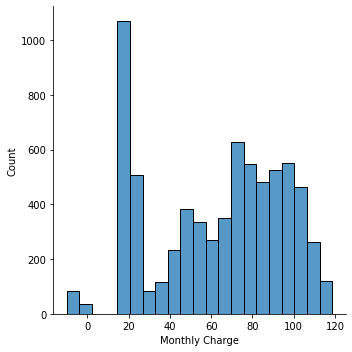

In [167]:
sns.displot(data=churn_df, x="Monthly Charge")

Интересное распределение: 2 больших пика в районе 20, и далее нормальное распределение.
Предположим, что это связано с тем, что есть услуги дешевле и дороже. Причем, которые дороже, связаны с неким накопительным эффектом - чем больше расход по услуге, тем выше плата.

In [168]:
churn_df \
    .groupby('Internet Service', as_index=False) \
    .agg({'Monthly Charge': 'mean'})

,Internet Service,Monthly Charge
0,No,20.613925
1,Yes,75.484992


Здесь гипотеза подтверждается: средняя плата без подключения интернета 20,61, с интернетом - 75,48.

Разделим эти категории клиентов и посмотрим, есть ли какие-то тенденции по ушедшим клиентам:

In [169]:
no_internet_service_df = churn_df[churn_df['Internet Service'] == 'No']
with_internet_service_df = churn_df[churn_df['Internet Service'] == 'Yes']

In [170]:
churn_df \
    .groupby(['Customer Status', 'Internet Service'], as_index=False) \
    .agg({'Age': 'count'}) \
    .pivot(index='Customer Status', columns='Internet Service', values='Age')

Internet Service,No,Yes
Customer Status,,
Churned,113,1756
Joined,182,272
Stayed,1231,3489


Разница видна достаточно хорошо. Судя по всему, условия конкурентов по тарифам с интернетом лучше, поэтому клиенты склонны к уходу.
Посмотрим данные по клиентам с интернетом:

In [171]:
with_internet_service_df \
    .groupby('Customer Status') \
    .agg({'Monthly Charge': 'mean'})

,Monthly Charge
Customer Status,
Churned,76.803303
Joined,58.092279
Stayed,76.177415


Разницы между оставшимся и ушедшими клиентами нет. Значит кто-то согласен платить, а кто-то нет. Либо у кого-то есть возможность сменить компанию, а у кого-то нет. В общем, здесь причина лежит не в самой цене услуги, а включаются другие факторы.

Посмотрим разбивку ушедших клиентов по причинам ухода:

In [172]:
churned_customers_with_internet_service_df = with_internet_service_df[with_internet_service_df['Customer Status'] == 'Churned']

In [173]:
churned_customers_with_internet_service_df \
    .groupby('Churn Category') \
    .agg({'Monthly Charge': 'mean'})

,Monthly Charge
Churn Category,
Attitude,77.571507
Competitor,77.286508
Dissatisfaction,73.976923
Other,75.696369
Price,79.534770


Здесь также сильной разницы нет.

In [174]:
churned_customers_with_internet_service_df \
    .groupby('Churn Category') \
    .agg({'Monthly Charge': 'count'})

,Monthly Charge
Churn Category,
Attitude,272
Competitor,819
Dissatisfaction,312
Other,179
Price,174


Тут также основная причина - уход к конкурентам. Но только по нашим данным не удалось найти однозначный вывод, т.к. у конкурентов предложение лучше, и для этого уже нужно изучать данные рынка в целом.

Посмотрим, как распределены ушедшие клиенты с подключенным интернетом по городам:

In [175]:
churned_customers_with_internet_service_df \
    .groupby('City') \
    .agg({'Age': 'count', 'Monthly Charge': 'mean'}) \
    .sort_values('Age', ascending=False) \
    .head(10)

,Age,Monthly Charge
City,,
San Diego,174,76.324138
Los Angeles,75,75.678000
San Francisco,30,81.690000
San Jose,28,71.850000
Fallbrook,24,74.345833
Sacramento,23,79.480435
Temecula,22,81.184091
Escondido,16,80.090625
Long Beach,14,71.564286


И тут также нет однозначного тренда.
Так что остановимся на выводе о более интересном предложении конкурентов, и, исходя из этого, наше предложение на данный момент находится не в рынке. Необходимо изучать внутренние ресурсы компании и оценить возможность делать рыночное предложение. Здесь также важный нюанс, что клиенты со статусом *Joined* имеют высокую долю вероятности стать *Churned*, т.к. тенденция ухода высока у клиентов, которые присоединились недавно.

**5. Выводы**

Любой срез данных дает схожие выводы - предложение компании по услугам находятся не в рынке, и клиенты вынуждены выбирать конкурентов. Поэтому необходимо оценить рыночные условия и пересмотреть предложение.

При этом ежемесячная плата схожая у ушедших и оставшихся клиентов. Вполне возможно, что предложение клиентов имеет преимущества не в цене, а в самих условиях. Возможно, что они предлагают больше и лучше за ту же цену.

Также стоит обратить внимания на отдельные локации, в частности - Сан Диего. В данном городе ситуация выглядит плачевной, т.к. там уже потеряно 65% клиентов. Даже лучшать начать оттуда, там будет более наглядно заметна разница предложений на рынке, т.к. там уход клиентов принимает массовый характер.